# COVID Dashboard

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from pathlib import Path
import numpy as np
import pandas as pd
import datetime
import time

In [2]:
from src.phac import PHAC

can = PHAC()

In [3]:
def doubling_time(r):
    if r > 0:
        return f"doubling in {np.log(2) / np.log1p(r): .1f}"
    elif r == 0:
        return "stationary"
    else:
        return f"half life {-np.log(2) / np.log1p(r): .1f}"
    
def rate_to_dbl_in(nper):
    if nper == np.inf:
        return 0
    else:
        return np.expm1(np.log(2) / nper)
    
def zeros(ser):
    """
    Return the list of indices where a series intercepts the x-axis
    
    :param ser: pandas.Series
    """
    state = np.sign(ser[0])
    zeros = []
    for idx, val in ser.items():
        if np.sign(val) != state:
            if np.isnan(state):
                state = np.sign(val)
            else:
                zeros.append(idx)
                state = np.sign(val)
    return zeros

# Notes on Modeling COVID

## Introduction

The data sets available to us give us, for each location, a multi-dimensional timeseries.  Each time observation can be assumed to include the following features:

* $\tau_{t}$ - the number of individuals tested as a proportion of the population
* $\pi_{t}$ - the positivity rate.  Note $\pi \sim \frac{\nu}{\tau}$.  Depending on the reporting protocols, new cases reported at time $t$ may not be the result of tests reported at $t$.
* $\nu_{t}$ - the number of new cases as a proportion of the population
* $\delta_{t}$ - the number of deaths as a proportion of the population

We may also have

* $\rho_{t}$ the number of resolved cases as a proportion of the population
* $\eta_{t}$ the number of hospitalizations as a proportion of the population

Derived variables include:

* $T_{t} = \sum^{t}_{k=0}{\nu_{k}}$ - total cases as a proportion of the population

Note, the new cases reported at a give time, $t$, may not be the results of testing at $t$

## Processes driving disease spread

Viral spread is the result of the following processes:

* Transmission (or contagion) - this is a function of the virus
* Population immunity - this is a function of disease prgress and the state of vaccinations
* Exposure (or contact) - this is a function if population behaviour
* Resolution - this is a property of the virus and the treatment regime

### Exposure Model

We model exposure or contact by a random variable $E$ over $R_{\ge 0}$ where $P(E=x)$ is interpreted as the probability that a member of the population is exposed to viral load $x$.  The exponential distribution is a natural model for exposure. 

The exposure model varies with time and location and is affected by population behaviour.

Public health interventions aim to change population behaviour.

* Hand washing reduces exposure from fomites.
* Social distancing (maintaining distance from others) reduces exposure from droplets.
* Mask wearing reduces the amount of virus in the environment and reduces exposure from droplets in the air.  Note mask wearing may also increase exposure to fomites.
* Social isolation (reducing the number and duration of contacts) reduces exposure to the virus in all forms.  
* Testing, contact tracing, and quarantine aim to isolate eliminate reduce the viral load in social environments.
* Facility controls (e.g, ventilation) reduce viral load in environment

If we choose the exponential distribution, then the p.d.f is $P(E=x) = \lambda e^{-\lambda x)}$ and the c.d.f is $P(E \le x) = (1 - e^{-\lambda x})$

So exposure model is parameterized by a series $\{\lambda^E_t\}$ for each location.

### Transmission (Contagion Model)

We model transmission as a mixture of exponential distributions.  Only the latent mixture variable changes with time.  We have a set of strains $S$ and a family $\{C_s | s \in S\}$ of exponential distributions.  Each $C_s$ represents the probability that a susceptible member of the population is infected when exposed to a viral load $x$. (Note, we may want to consider using a logistic distribution if infection has a hard threshold).  At any point in time we have a distribution $P_t(S=s) = p_t(s)$.

So the transmission model is parameterized by $\{\lambda^S_s\}$ and $|S|$-wide series $<p_t(s)>$ at each location

### Immunity Model

Acquired population immunity changes the transmission model.  If an individual has some degree of immunity then the transmission threshold for that individual increases.

Immunity is a function of how the individual acquired (i.e., infection, vaccine type, vaccine dosage) and potentially the time since it was acquired (immunity diminishes with time).    Let $\theta$ be the effectiveness of an individual's immunity.  This means that under equivalent exposure scenarios $P(\text{infection} | \text{immunity}) = (1-\theta)\ P(\text{infection} | \text{no immunity})$. 

Let $I_{s,t}$ be the random variable over the sample space $[0,1]$ representing population immunity at $t$ for strain $s$; that is $p_{I_{s,t}}(\theta)$ is the probability that a random individual has immunity with effectiveness $\theta$.  The contagion (transmission) for strain $s$ at $t$ is modelled by the scale mixture (compound random variable) $C_{s,t}(\lambda_s, I_{s,t})$.  The pdf for $C_{s,t}$ is goven by:

$$p_{C_{s,t}}(x) = \int{ \lambda_{s, \theta} e^{-\lambda_{s,\theta} x} p_{I_{s,t}}(\theta) d \theta}$$

where $\lambda_{s,\theta} = \frac{\lambda_s}{1 - \theta}$. Need to prove this is well defined for reasonable immunity models.


### Resolution Model.

Infections resolve after a period of time.  Either the infected individual recovers and is no longer infectious or the infected individual dies and is no longer infectious.  We assume that resolution is independent of time and virus strain.  Resolution can be assumed to follow a poisson distribution $r(n;\lambda)$ representing the probability that a case resolves after $n$ time periods. Let $Res$ be the random variable representing the resolution model.

## Growth Model for a Single Location

Transmission rate at time $t$ is given by

$$ R_t = \sum_{s \in S}{p_t(s) \int_{x}{P_t(E=x) P(C_s=x)} dx} = \sum_{s \in S}{ p_t(s) \frac{\lambda^E_t \lambda^S_s}{\lambda^E_t + \lambda^S_s} }$$

Let $\alpha_t(k)$ be the active cases of age $k$ at time $t$ as a proportion of the population, and let $\alpha_t = \sum_{k}{\alpha_t(k)}$.  We have,

$$\alpha_{t+1}(k+1) = \alpha_t(k) Prob(Res > k) \text{ and } \alpha_{t+1}(0) = \alpha_t R_t$$
 



## Estimating True Incidence

Let $\eta_t$ be the incidence rate (proportion of the population) infected at time $t$.  


In [4]:

fit_win = 14
meas_win = 7
tests = can.var_by_location("new_tests_rate", *can.provinces, ma_window=1)*1000
cases = can.var_by_location("new_cases_rate", *can.provinces, ma_window=1)
deaths = can.var_by_location("new_deaths_rate", *can.provinces, ma_window=meas_win).fillna(0)
posrate = can.pos_test_rate(meas_win, *can.provinces)
posgrowth = can.growth_rate("pos_test_rate", meas_win, *can.provinces)

/Users/bill/IdeaProjects/covid-19/src/dataset.py:150: RuntimeWarning: invalid value encountered in power
  growth = lambda x: np.power(x, 1 / window)


In [5]:
pt_1day = can.pos_test_rate(1, *can.provinces)

pt_tests_dict = {}
for loc in can.provinces:
    a = (100*pt_1day[loc]).apply(lambda x: f"{x:.2f}")
    b = tests[loc].apply(lambda x: f"{x:.2f}")
    pt_tests_dict[loc] = a + " / " + b

pt_tests_df = pd.DataFrame(pt_tests_dict)
pt_tests_df[-7:]

,Canada,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon,Northwest Territories,Nunavut
date,,,,,,,,,,,,,,
2021-05-30,3.69 / 1.76,0.57 / 2.36,0.00 / 4.36,0.34 / 6.06,0.50 / 2.32,1.47 / 2.49,3.08 / 2.28,inf / 0.00,7.63 / 1.90,inf / 0.00,inf / 0.00,nan / 0.00,nan / 0.00,0.00 / 3.41
2021-05-31,2.90 / 1.91,0.17 / 2.27,0.46 / 2.71,0.27 / 6.48,0.78 / 1.64,1.65 / 1.95,3.45 / 1.80,5.01 / 4.30,6.46 / 1.48,inf / 0.00,1.71 / 2.41,nan / 0.00,0.92 / 2.41,0.00 / 0.89
2021-06-01,2.25 / 1.92,0.60 / 1.92,0.00 / 1.91,0.31 / 3.90,0.56 / 1.15,0.96 / 2.53,3.84 / 1.24,8.38 / 1.98,5.00 / 1.46,1.17 / 4.04,4.19 / 0.85,nan / 0.00,0.00 / 0.66,0.00 / 1.19
2021-06-02,3.17 / 1.71,1.79 / 1.82,0.00 / 3.99,0.38 / 3.75,0.96 / 1.59,1.25 / 2.69,3.62 / 1.38,8.77 / 2.17,4.72 / 2.37,10.00 / 0.93,3.76 / 1.00,nan / 0.00,0.00 / 1.99,0.00 / 3.56
2021-06-03,2.42 / 2.36,0.33 / 3.47,0.52 / 2.40,0.59 / 4.36,1.23 / 1.66,0.90 / 3.45,2.74 / 2.16,11.95 / 2.17,5.73 / 1.94,3.56 / 1.88,2.90 / 1.33,nan / 0.00,0.00 / 2.46,0.00 / 2.03
2021-06-04,2.37 / 2.29,0.13 / 2.85,0.00 / 4.25,0.29 / 5.36,0.61 / 2.10,1.12 / 2.90,2.67 / 2.33,9.49 / 2.47,3.42 / 2.21,3.58 / 1.54,3.13 / 1.13,nan / 0.00,0.00 / 2.02,1.96 / 1.30
2021-06-05,2.87 / 1.53,0.31 / 3.06,0.00 / 2.37,0.39 / 4.69,0.62 / 1.85,inf / 0.00,2.31 / 2.19,7.26 / 2.76,4.90 / 1.71,5.04 / 1.32,0.00 / 1.19,nan / 0.00,0.00 / 1.55,0.00 / 3.00


In [6]:
location = "Ontario"

In [7]:
from src.models.growth import GeometricProcess

def predict_on_growth_trend(model, k, trend_win=14):
    """
    Predict positivity rate out k time periods based on model
    """
    growth = np.exp(model["LogGrowthRate"].values)
    m = (growth[-1] - growth[-trend_win]) / trend_win
    pred_growth = np.array([growth[-1]+ m * (j+1) for j in range(k)])
    pred_log_growth = np.log(pred_growth)
    log_pt_0 = (model["PredictedLogValue"].values)[-1]
    result = log_pt_0 + np.array([np.sum(pred_log_growth[0:j+1]) for j in range(k)])
    return pred_growth, np.exp(result)
    

proc = GeometricProcess(est_per=fit_win)
proc.fit(posrate[location])

# Get sign changes in growth rate
grzeros = zeros(proc.model["LogGrowthRate"])

x = [idx.date() for idx in proc.model.index]
x_shifted = proc.model.index - proc.est_per * pd.Timedelta("1 day")

model = np.exp(proc.model)
model.columns = ["Growth Rate", "Prior Positivity Rate", "Error", "Predicted Positivity Rate", "Measured Positivity Rate"]
model[-7:]

,Growth Rate,Prior Positivity Rate,Error,Predicted Positivity Rate,Measured Positivity Rate
2021-05-30,0.971329,0.065123,1.022364,0.044617,0.039526
2021-05-31,0.967447,0.064787,1.027246,0.042134,0.037795
2021-06-01,0.964069,0.064122,1.027155,0.039848,0.036443
2021-06-02,0.960350,0.063414,1.026353,0.037477,0.034027
2021-06-03,0.956012,0.062793,1.023222,0.034989,0.031495
2021-06-04,0.952993,0.061408,1.019402,0.032839,0.030274
2021-06-05,0.951406,0.059484,1.014190,0.031129,0.030008


In [8]:
predict_on_growth_trend(proc.model, 45)

(array([0.94914407, 0.94688222, 0.94462037, 0.94235852, 0.94009667,
        0.93783482, 0.93557297, 0.93331112, 0.93104927, 0.92878741,
        0.92652556, 0.92426371, 0.92200186, 0.91974001, 0.91747816,
        0.91521631, 0.91295446, 0.91069261, 0.90843076, 0.90616891,
        0.90390706, 0.90164521, 0.89938336, 0.8971215 , 0.89485965,
        0.8925978 , 0.89033595, 0.8880741 , 0.88581225, 0.8835504 ,
        0.88128855, 0.8790267 , 0.87676485, 0.874503  , 0.87224115,
        0.8699793 , 0.86771745, 0.86545559, 0.86319374, 0.86093189,
        0.85867004, 0.85640819, 0.85414634, 0.85188449, 0.84962264]),
 array([0.02954547, 0.02797608, 0.02642677, 0.0249035 , 0.02341169,
        0.0219563 , 0.02054172, 0.01917182, 0.01784991, 0.01657877,
        0.01536065, 0.01419729, 0.01308993, 0.01203933, 0.01104583,
        0.01010932, 0.00922935, 0.0084051 , 0.00763545, 0.00691901,
        0.00625414, 0.00563902, 0.00507164, 0.00454987, 0.0040715 ,
        0.00363421, 0.00323567, 0.00287351, 0.

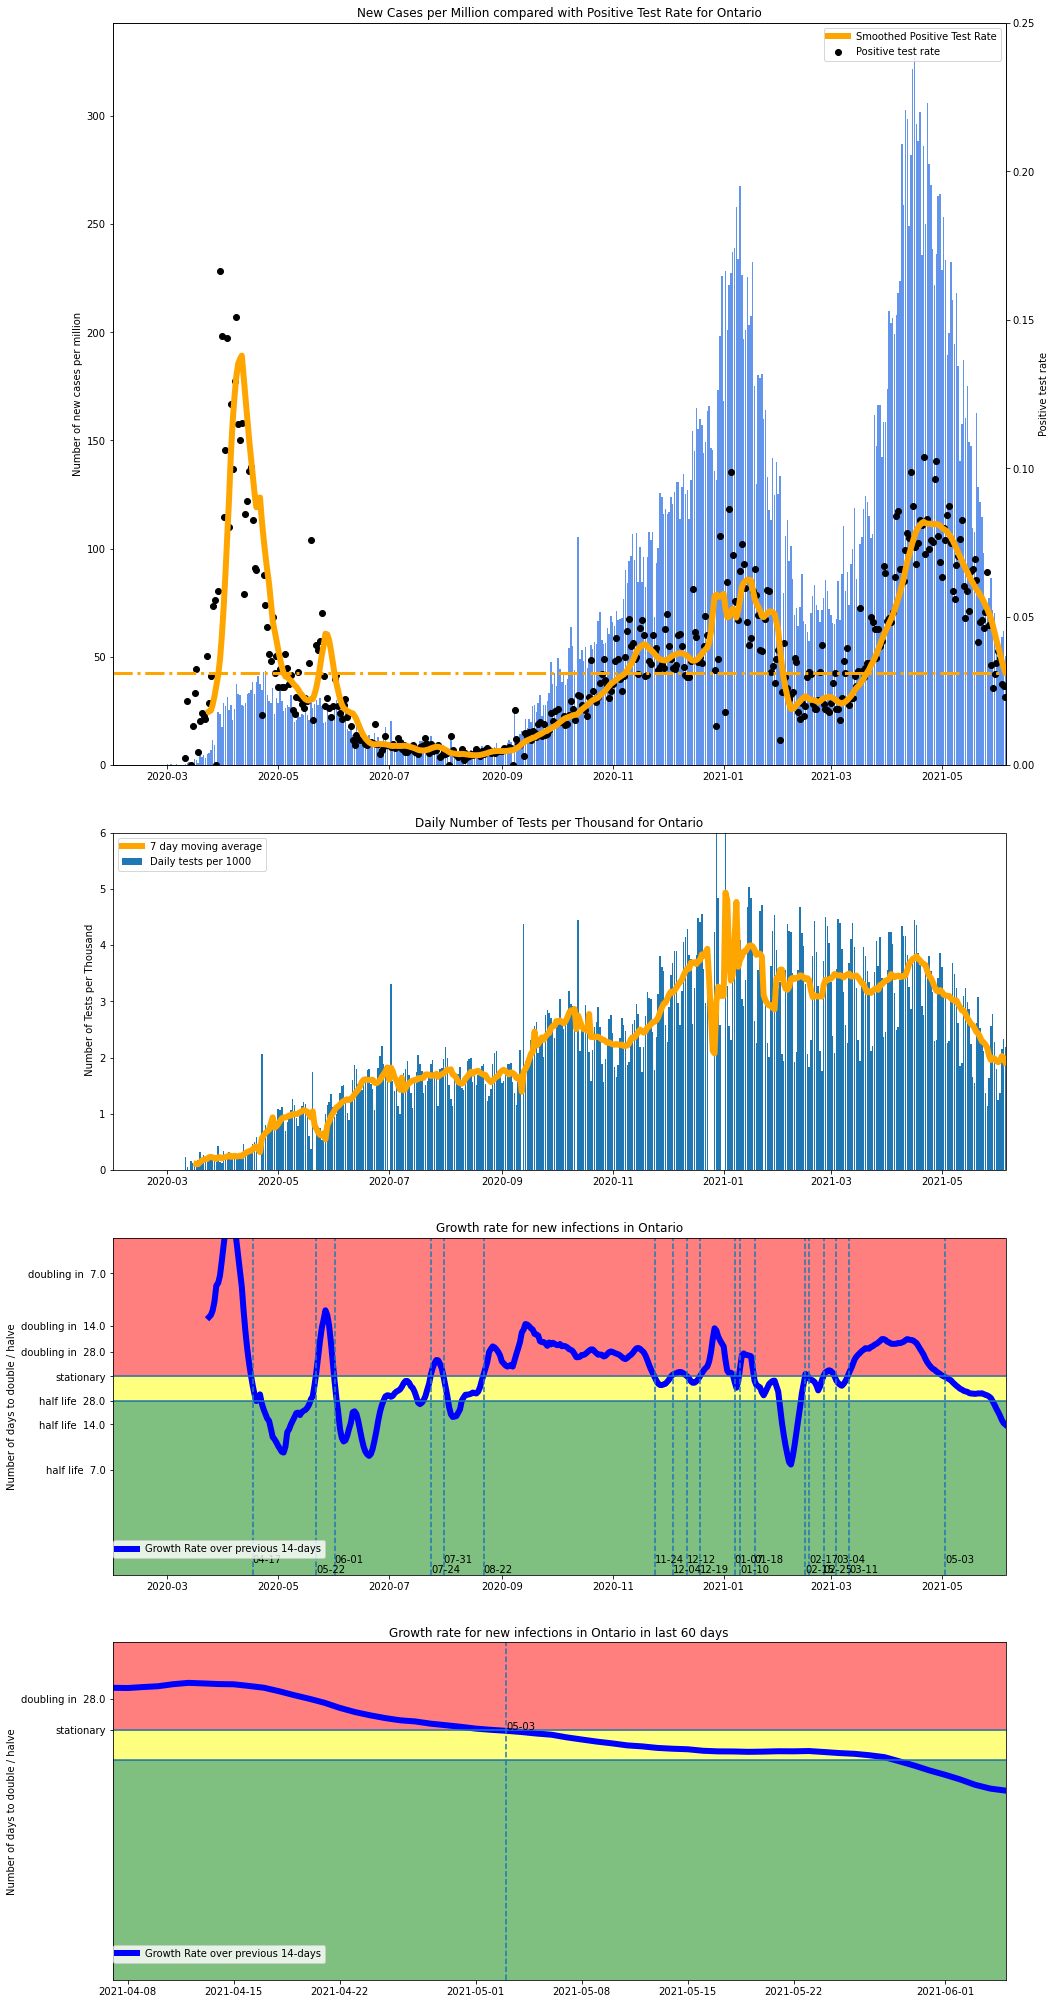

In [9]:
save_file = True
    
doubling_ticks = [-2, -3, -4, -5, -6, -7, -14, -28, np.inf, 28, 14, 7, 6, 5, 4, 3, 2]
doubling_tick_locs = [rate_to_dbl_in(nper) for nper in doubling_ticks]
doubling_tick_labels = [doubling_time(tick) for tick in doubling_tick_locs]
doubling_hlines = [rate_to_dbl_in(nper) for nper in [-28, np.inf]]


#dashboard, db_ax = plt.subplots(nrows=2, ncols=1, sharex=False, figsize=(16,24))
dashboard = plt.figure(figsize=(16,36))
db_ax = []
gs = GridSpec(5,1, figure=dashboard)
db_ax.append(dashboard.add_subplot(gs[0:2,:]))
db_ax.append(dashboard.add_subplot(gs[3,:]))
db_ax.append(dashboard.add_subplot(gs[2,:]))
db_ax.append(dashboard.add_subplot(gs[4,:]))

db_ax[0].bar(cases.index, cases[location]*1000000, color="cornflowerblue")
#db_ax[0].plot(cases.index, deaths[location], color="black")
db_ax[0].set_ylabel(f"Number of new cases per million")
db_ax0r = db_ax[0].twinx()
db_ax0r.plot(x, np.exp(proc.model["PredictedLogValue"]), 
         c="orange", lw=6, label="Smoothed Positive Test Rate")
db_ax0r.scatter(pt_1day.index, pt_1day[location], 
                c="black", label=f"Positive test rate" )
db_ax0r.set_ylim((0, 0.25))
db_ax0r.set_ylabel("Positive test rate")
db_ax[0].set_xlim((min(cases.index), max(cases.index)))
db_ax[0].set_title(f"New Cases per Million compared with Positive Test Rate for {location}")
db_ax0r.legend()

db_ax0r.axhline(y=np.exp(proc.model.iloc[-1]["PredictedLogValue"]), lw=3, linestyle="-.", c="orange")

#db_ax[1].plot(posgrowth.index, posgrowth[location], lw=6, label="Growth Rate")
#posgrowth_ma = posgrowth.rolling(14).mean()[location]
#db_ax[1].plot(posgrowth.index, posgrowth_ma, lw=6, c="orange", label="14-day moving average")
db_ax[1].plot(x, np.exp(proc.model["LogGrowthRate"])-1, lw=6,
            c="blue", label=f"Growth Rate over previous {fit_win}-days")
db_ax[1].set_xlim((min(cases.index), max(cases.index)))
db_ax[1].set_ylim( (-0.2, 0.14))
db_ax[1].set_yticks(doubling_tick_locs[5:-5])
db_ax[1].set_yticklabels(doubling_tick_labels[5:-5])
db_ax[1].set_ylabel("Number of days to double / halve")
db_ax[1].set_title(f"Growth rate for new infections in {location}")
db_ax[1].legend(loc=(0, 0.05))

for y in doubling_hlines:
    db_ax[1].axhline(y=y)

db_ax[1].axhspan(0, db_ax[1].get_ylim()[1], color="red", alpha=0.5)  # danger zone
db_ax[1].axhspan(rate_to_dbl_in(-28), 0, color="yellow", alpha=0.5)  # Time to pay attention
db_ax[1].axhspan(db_ax[1].get_ylim()[0], rate_to_dbl_in(-28), color="green", alpha=0.5)  # Comfort zone

# if location == "Ontario":
#     db_ax[1].axvline(x="2020-05-19", linestyle="-", lw=6)
#     db_ax[1].annotate("Phase 1  \nopening begins  ", 
#                       ("2020-05-19", 0.1),
#                      horizontalalignment="right")
#     db_ax[1].axvline(x="2020-06-12", linestyle="-", lw=6)
#     db_ax[1].annotate("Phase 2  \nopening begins  ", 
#                       ("2020-06-12", 0.1),
#                      horizontalalignment="right")
#     db_ax[1].axvline(x="2020-07-17", linestyle="-", lw=6)
#     db_ax[1].annotate("Phase 3  \nopening begins  ", 
#                       ("2020-07-17", 0.1),
#                      horizontalalignment="right")
#     db_ax[1].axvline(x="2020-09-23", linestyle="-", lw=6)
#     db_ax[1].annotate("Bars and restaurants  \nordered to close early  ", 
#                       ("2020-09-23", 0.1),
#                      horizontalalignment="right")
#     db_ax[1].axvline(x="2020-10-14", linestyle="-", lw=6)
#     db_ax[1].annotate("Modified Phase 2  \nPeel, Toronto, Ottawa  ", 
#                       ("2020-10-14", 0.075),
#                      horizontalalignment="right")
#     db_ax[1].axvline(x="2020-12-26", linestyle="-", lw=6)
#     db_ax[1].annotate("Province Wide Lock Down", 
#                       ("2020-12-26", 0.1),
#                      horizontalalignment="right")
#     db_ax[1].axvline(x="2021-01-13", linestyle="-", lw=6)
#     db_ax[1].annotate("Emergency Stay at Home Order", 
#                       ("2021-01-13", 0.075),
#                      horizontalalignment="right")



anpos = 1
for idx in grzeros:
    db_ax[1].axvline(x=idx, linestyle="--")
    db_ax[1].annotate(str(idx.date())[-5:], (idx, 0.002 + db_ax[1].get_ylim()[0] + anpos * 0.01))
    anpos = (anpos + 1) % 2

tests_ave = can.var_by_location("new_tests_rate", location, ma_window=meas_win) * 1000
db_ax[2].bar(tests.index, tests[location], label="Daily tests per 1000")
db_ax[2].plot(tests_ave.index, tests_ave, c="orange", lw=6, label=f"{meas_win} day moving average")
db_ax[2].set_title(f"Daily Number of Tests per Thousand for {location}")
db_ax[2].set_ylabel(" Number of Tests per Thousand")
db_ax[2].set_xlim((min(tests.index), max(tests.index)))
db_ax[2].set_ylim((0, 6))
db_ax[2].legend(loc="upper left")

# zoom in on growth rate
zoom = 60
db_ax[3].plot(x[-zoom:], np.exp(proc.model[-zoom:]["LogGrowthRate"])-1, lw=6,
            c="blue", label=f"Growth Rate over previous {fit_win}-days")
db_ax[3].set_xlim( ( min(x[-zoom:]), max(x[-zoom:]) ) )
db_ax[3].set_ylim( (-0.2, 0.07))
db_ax[3].set_yticks(doubling_tick_locs[8:-7])
db_ax[3].set_yticklabels(doubling_tick_labels[8:-7])
db_ax[3].set_ylabel("Number of days to double / halve")
db_ax[3].set_title(f"Growth rate for new infections in {location} in last {zoom} days")
db_ax[3].legend(loc=(0, 0.05))

for y in doubling_hlines:
    db_ax[3].axhline(y=y)

db_ax[3].axhspan(0, db_ax[1].get_ylim()[1], color="red", alpha=0.5)  # danger zone
db_ax[3].axhspan(rate_to_dbl_in(-28), 0, color="yellow", alpha=0.5)  # Time to pay attention
db_ax[3].axhspan(db_ax[1].get_ylim()[0], rate_to_dbl_in(-28), color="green", alpha=0.5)  # Comfort zone

for idx in grzeros:
    if idx in x[-zoom:]:
        db_ax[3].axvline(x=idx, linestyle="--")
        db_ax[3].annotate(str(idx.date())[-5:], (idx, 0))

    


if save_file:
    as_of = x[-1]
    savefile = f"{as_of}_COVID_Dashboard_{location}.png"
    plt.savefig(Path.home().joinpath("Documents/COVID/" + savefile), format="png")




In [10]:
ptr = list(map(doubling_time, np.exp(proc.model["LogGrowthRate"])-1))
ptr[-10:]

['half life  33.8',
 'half life  31.4',
 'half life  27.1',
 'half life  23.8',
 'half life  20.9',
 'half life  18.9',
 'half life  17.1',
 'half life  15.4',
 'half life  14.4',
 'half life  13.9']

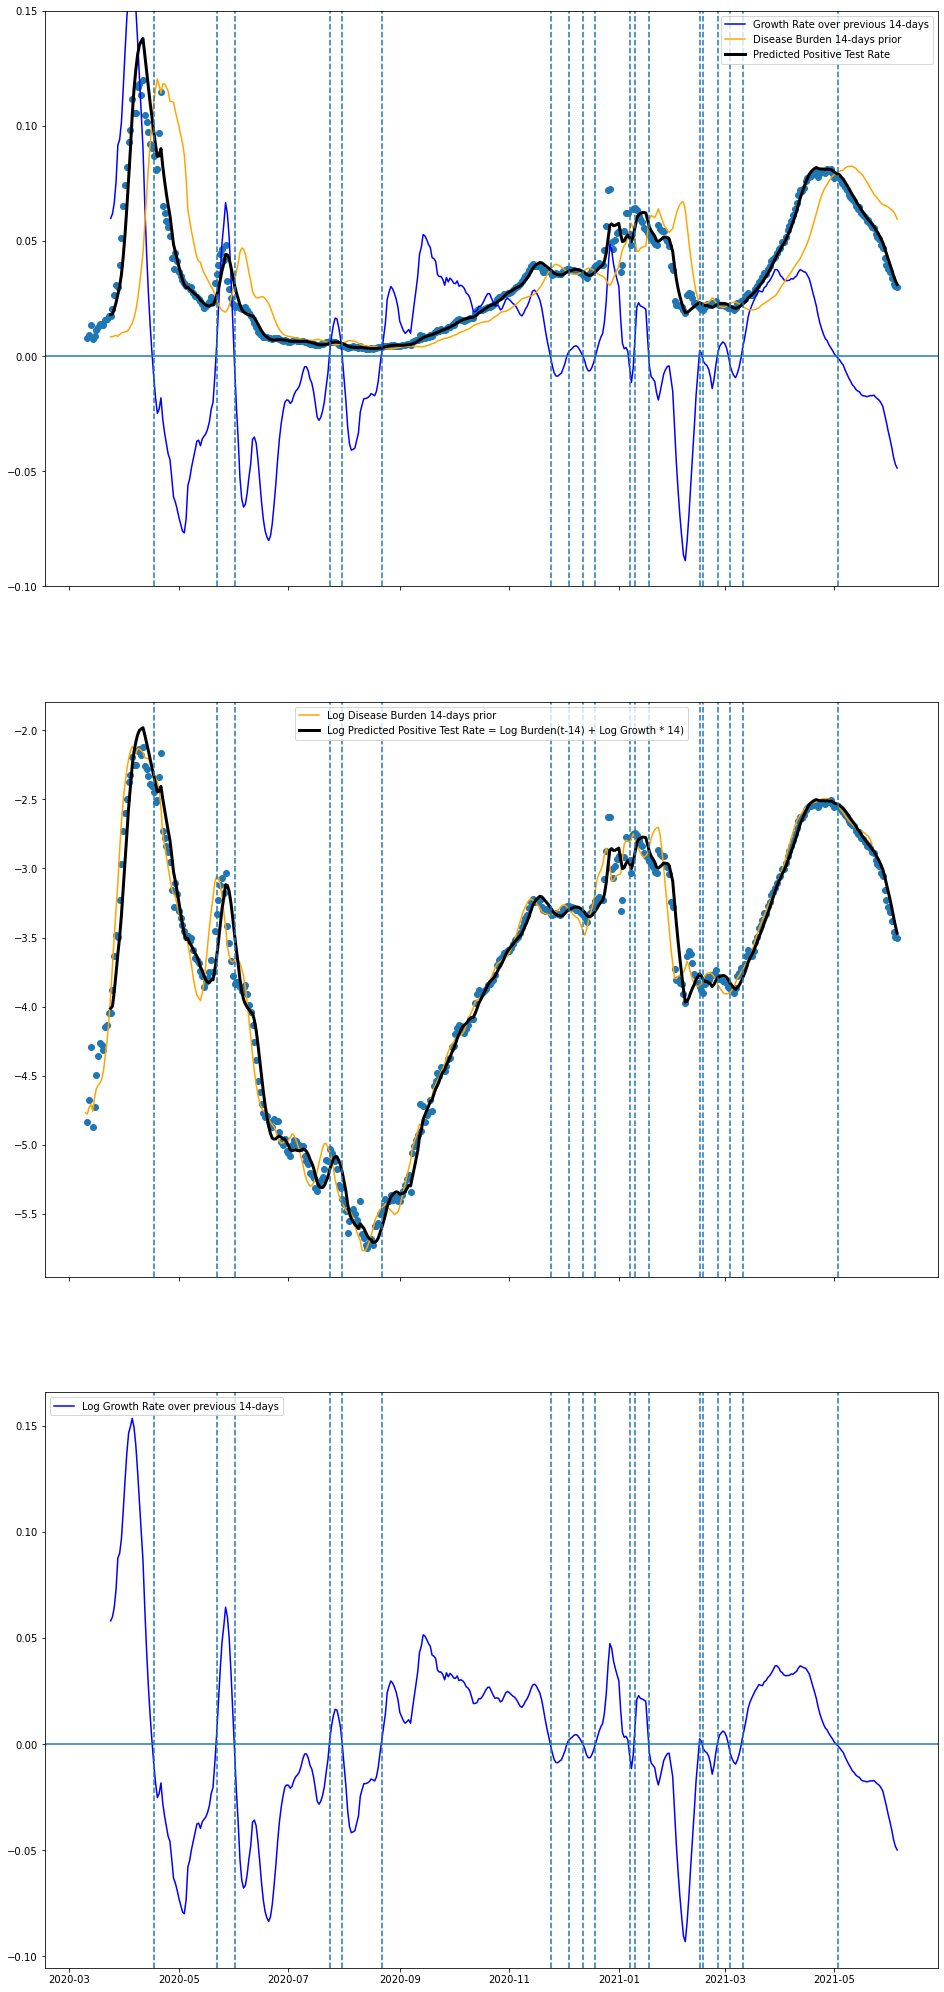

In [11]:
f1, ax1 = plt.subplots(nrows=3, ncols=1, figsize=(16,36), sharex=True)

ax1[0].plot(x, np.exp(proc.model["LogGrowthRate"])-1, 
            c="blue", label=f"Growth Rate over previous {fit_win}-days")
ax1[0].plot(x, np.exp(proc.model["LogPriorProcessLoad"]), 
         c="orange", label=f"Disease Burden {fit_win}-days prior")
ax1[0].plot(x, np.exp(proc.model["PredictedLogValue"]), 
         c="black", lw=3, label="Predicted Positive Test Rate")
ax1[0].scatter(posrate.index, posrate[location] )
ax1[0].set_ylim((-0.1, 0.15))
ax1[0].legend()

for idx in grzeros:
    ax1[0].axvline(x=idx, linestyle="--")
ax1[0].axhline(y=0)

#ax1[1].plot(posrate.index[x], [fit[0][0] for fit in fits], c="blue", label="Log Growth Rate")
ax1[1].plot(x_shifted, proc.model["LogPriorProcessLoad"], 
         c="orange", label=f"Log Disease Burden {fit_win}-days prior")
ax1[1].plot(x, proc.model["PredictedLogValue"], 
         c="black", lw=3, 
         label=f"Log Predicted Positive Test Rate = Log Burden(t-{fit_win}) + Log Growth * {fit_win})")
ax1[1].scatter(posrate.index, np.log(posrate[location]) )
#ax1[1].set_ylim((-0.1, 0.1))
ax1[1].legend()

for idx in grzeros:
    ax1[1].axvline(x=idx, linestyle="--")

ax1[2].plot(x, proc.model["LogGrowthRate"], 
            c="blue", label=f"Log Growth Rate over previous {fit_win}-days")
#ax1[2].plot(x, lgr, 
#            c="red", label=f"Log Growth Rate Core Processes")
ax1[2].legend()

ax1[2].axhline(y=0)
for idx in grzeros:
    ax1[2].axvline(x=idx, linestyle="--")

In [12]:
ont = pd.read_csv("https://data.ontario.ca/dataset/f4112442-bdc8-45d2-be3c-12efae72fb27/resource/455fd63b-603d-4608-8216-7d8647f43350/download/conposcovidloc.csv")

In [13]:
ont

,Row_ID,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Outbreak_Related,Reporting_PHU_ID,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
0,1,2020-05-05,2020-05-12,2020-05-12,2020-05-11,30s,MALE,OB,Resolved,Yes,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
1,2,2020-04-17,2020-04-20,2020-04-20,2020-04-19,30s,FEMALE,OB,Resolved,Yes,3895,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
2,3,2020-06-08,2020-06-12,2020-06-12,2020-06-11,30s,MALE,NO KNOWN EPI LINK,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
3,4,2020-05-20,2020-05-23,2020-05-23,2020-05-22,50s,FEMALE,CC,Resolved,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
4,5,2020-03-28,2020-04-03,2020-04-03,2020-04-02,80s,MALE,CC,Fatal,NaN,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
536077,536078,2021-05-01,2021-05-05,2021-05-05,2021-05-04,40s,MALE,NO KNOWN EPI LINK,Resolved,NaN,2230,Durham Region Health Department,605 Rossland Road East,Whitby,L1N 0B2,www.durham.ca/en/health-and-wellness/health-an...,43.898605,-78.940341
536078,536079,2021-05-03,2021-05-05,2021-05-05,2021-05-04,40s,MALE,NO KNOWN EPI LINK,Resolved,NaN,2230,Durham Region Health Department,605 Rossland Road East,Whitby,L1N 0B2,www.durham.ca/en/health-and-wellness/health-an...,43.898605,-78.940341
536079,536080,2021-05-03,2021-05-05,2021-05-05,2021-05-04,30s,MALE,NO KNOWN EPI LINK,Resolved,NaN,2230,Durham Region Health Department,605 Rossland Road East,Whitby,L1N 0B2,www.durham.ca/en/health-and-wellness/health-an...,43.898605,-78.940341
536080,536081,2021-05-04,2021-05-05,2021-05-05,2021-05-04,30s,FEMALE,NO KNOWN EPI LINK,Resolved,NaN,3895,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358


In [14]:
ont.columns

Index(['Row_ID', 'Accurate_Episode_Date', 'Case_Reported_Date',
       'Test_Reported_Date', 'Specimen_Date', 'Age_Group', 'Client_Gender',
       'Case_AcquisitionInfo', 'Outcome1', 'Outbreak_Related',
       'Reporting_PHU_ID', 'Reporting_PHU', 'Reporting_PHU_Address',
       'Reporting_PHU_City', 'Reporting_PHU_Postal_Code',
       'Reporting_PHU_Website', 'Reporting_PHU_Latitude',
       'Reporting_PHU_Longitude'],
      dtype='object')

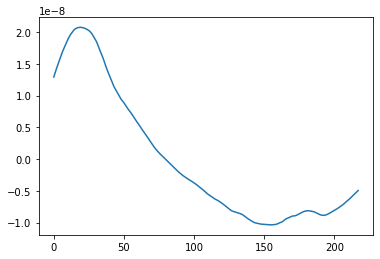

In [15]:
   

def cross_cov(s1,s2):
    """
    Return the cross covariance of s1 and s2
    """
    
    n = len(s1)
    max_lag = n // 2
    x1 = s1.values; m1 = np.mean(x1)
    x2 = s2.values; m2 = np.mean(x2)
    result = []
    for h in range(max_lag):
        result.append(
            sum([(x1[t] - m1) * (x2[t-h] - m2) for t in range(h,n)]) / n
        )
    return result

ccv = cross_cov(deaths[31:][location], posrate[31:][location])
plt.plot(range(len(ccv)), ccv)
        

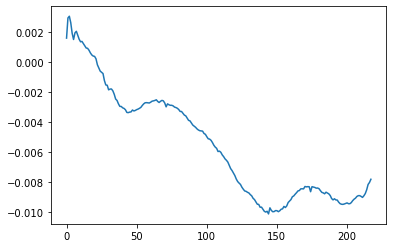

In [16]:
ccv = cross_cov(tests[31:][location], posrate[31:][location])
plt.plot(range(len(ccv)), ccv)
        

In [17]:
acv_matrix = np.cov(posrate[31:])
acv_matrix

/Users/bill/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2474: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


array([[0.00037041, 0.0004287 , 0.00038375, ...,        nan,        nan,
               nan],
       [0.0004287 , 0.00050795, 0.00044272, ...,        nan,        nan,
               nan],
       [0.00038375, 0.00044272, 0.00041041, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])

In [18]:
cases[-7:]

location,Alberta,British Columbia,Canada,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
date,,,,,,,,,,,,,,
2021-05-30,0.000088,4.623421e-05,0.000065,0.000210,0.000012,0.000013,0.000000,0.000020,2.439455e-19,0.000070,0.000000,0.000037,0.000145,0.0
2021-05-31,0.000059,4.118329e-05,0.000055,0.000215,0.000013,0.000004,0.000022,0.000017,2.439455e-19,0.000062,0.000013,0.000032,0.000096,0.0
2021-06-01,0.000047,3.574406e-05,0.000043,0.000166,0.000006,0.000011,0.000000,0.000012,2.439455e-19,0.000047,0.000000,0.000024,0.000073,0.0
2021-06-02,0.000093,3.768669e-05,0.000054,0.000190,0.000015,0.000033,0.000000,0.000014,2.439455e-19,0.000050,0.000000,0.000034,0.000112,0.0
2021-06-03,0.000067,3.865792e-05,0.000057,0.000259,0.000020,0.000011,0.000000,0.000026,2.439455e-19,0.000059,0.000013,0.000031,0.000111,0.0
2021-06-04,0.000055,3.554981e-05,0.000054,0.000234,0.000013,0.000004,0.000000,0.000015,2.541109e-05,0.000062,0.000000,0.000033,0.000076,0.0
2021-06-05,0.000066,4.065758e-20,0.000044,0.000200,0.000012,0.000010,0.000000,0.000018,2.439455e-19,0.000050,0.000000,0.000027,0.000084,0.0


<AxesSubplot:xlabel='date'>

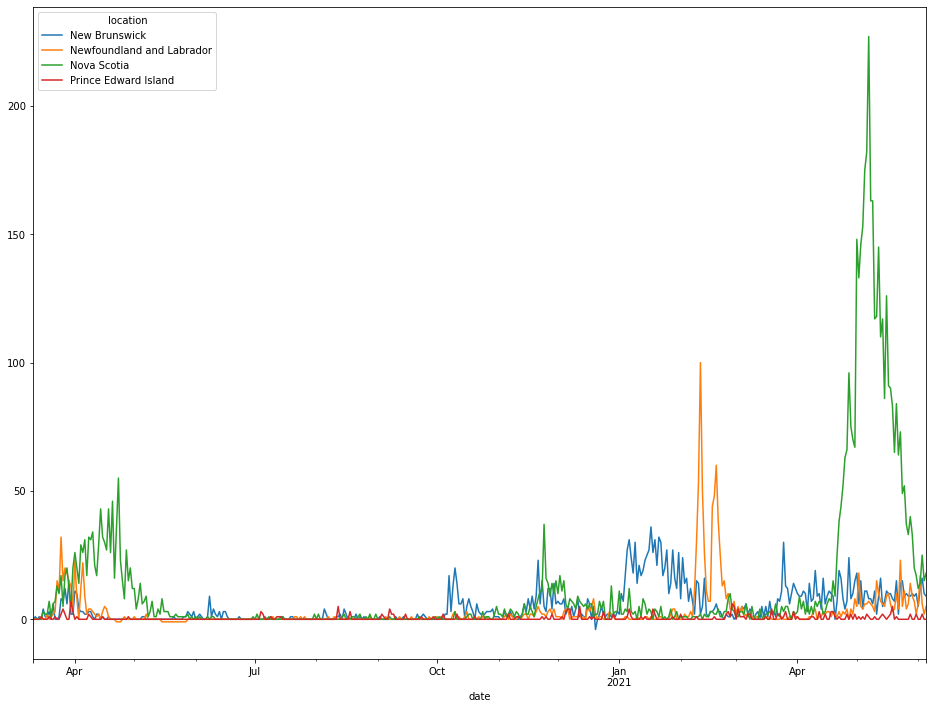

In [19]:
new_cases_abs = can.var_by_location("new_cases", *can.maritimes)
new_cases_abs.plot(figsize=(16,12))

<AxesSubplot:xlabel='date'>

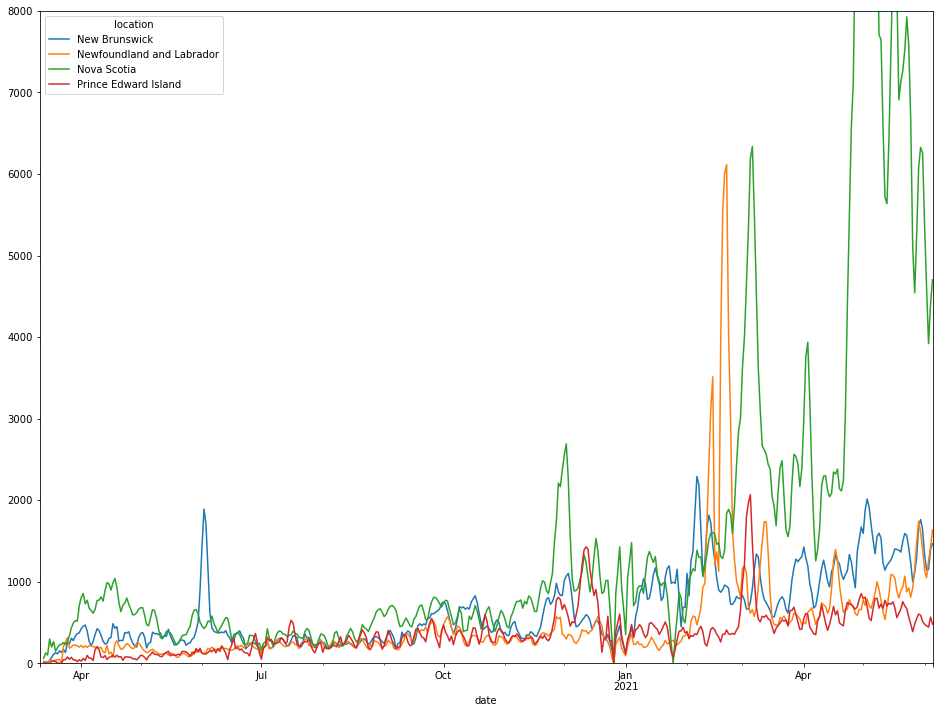

In [20]:
can.var_by_location("new_tests", *can.maritimes, ma_window=3).plot(figsize=(16,12), ylim=(0,8000))

In [21]:
import urllib.request as urllib
import json

url = 'https://data.ontario.ca/api/3/action/datastore_search?resource_id=455fd63b-603d-4608-8216-7d8647f43350'  
fileobj = urllib.urlopen(url)
data = json.loads(fileobj.read())
data

{'help': 'https://data.ontario.ca/api/3/action/help_show?name=datastore_search',
 'success': True,
 'result': {'include_total': True,
  'resource_id': '455fd63b-603d-4608-8216-7d8647f43350',
  'fields': [{'type': 'int', 'id': '_id'},
   {'info': {'notes': '', 'type_override': 'numeric', 'label': ''},
    'type': 'numeric',
    'id': 'Row_ID'},
   {'info': {'notes': '', 'type_override': 'timestamp', 'label': ''},
    'type': 'timestamp',
    'id': 'Accurate_Episode_Date'},
   {'info': {'notes': '', 'type_override': 'timestamp', 'label': ''},
    'type': 'timestamp',
    'id': 'Case_Reported_Date'},
   {'info': {'notes': '', 'type_override': 'timestamp', 'label': ''},
    'type': 'timestamp',
    'id': 'Test_Reported_Date'},
   {'info': {'notes': '', 'type_override': 'timestamp', 'label': ''},
    'type': 'timestamp',
    'id': 'Specimen_Date'},
   {'info': {'notes': '', 'type_override': '', 'label': ''},
    'type': 'text',
    'id': 'Age_Group'},
   {'info': {'notes': '', 'type_overrid

In [22]:
cols = {fld['id']: [] for fld in data['result']['fields']}
for row in data['result']['records']:
    for fld in cols:
        cols[fld].append(row.get(fld, np.nan))

ont_data_raw = pd.DataFrame(cols, index=cols["_id"])
ont_data_raw

,_id,Row_ID,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Outcome1,Outbreak_Related,Reporting_PHU_ID,Reporting_PHU,Reporting_PHU_Address,Reporting_PHU_City,Reporting_PHU_Postal_Code,Reporting_PHU_Website,Reporting_PHU_Latitude,Reporting_PHU_Longitude
1,1,1,2020-05-05T00:00:00,2020-05-12T00:00:00,2020-05-12T00:00:00,2020-05-11T00:00:00,30s,MALE,OB,Resolved,Yes,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
2,2,2,2020-04-17T00:00:00,2020-04-20T00:00:00,2020-04-20T00:00:00,2020-04-19T00:00:00,30s,FEMALE,OB,Resolved,Yes,3895,Toronto Public Health,"277 Victoria Street, 5th Floor",Toronto,M5B 1W2,www.toronto.ca/community-people/health-wellnes...,43.656591,-79.379358
3,3,3,2020-06-08T00:00:00,2020-06-12T00:00:00,2020-06-12T00:00:00,2020-06-11T00:00:00,30s,MALE,NO KNOWN EPI LINK,Resolved,None,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
4,4,4,2020-05-20T00:00:00,2020-05-23T00:00:00,2020-05-23T00:00:00,2020-05-22T00:00:00,50s,FEMALE,CC,Resolved,None,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
5,5,5,2020-03-28T00:00:00,2020-04-03T00:00:00,2020-04-03T00:00:00,2020-04-02T00:00:00,80s,MALE,CC,Fatal,None,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96,96,2020-04-23T00:00:00,2020-04-24T00:00:00,2020-04-24T00:00:00,2020-04-23T00:00:00,50s,MALE,CC,Resolved,None,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
97,97,97,2020-04-06T00:00:00,2020-05-23T00:00:00,2020-05-23T00:00:00,2020-04-16T00:00:00,20s,MALE,CC,Resolved,None,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
98,98,98,2020-05-26T00:00:00,2020-05-30T00:00:00,2020-05-29T00:00:00,2020-05-27T00:00:00,30s,MALE,OB,Resolved,None,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893
99,99,99,2020-05-31T00:00:00,2020-05-29T00:00:00,2020-05-29T00:00:00,2020-05-28T00:00:00,40s,FEMALE,OB,Resolved,Yes,2253,Peel Public Health,7120 Hurontario Street,Mississauga,L5W 1N4,www.peelregion.ca/health/,43.647471,-79.708893


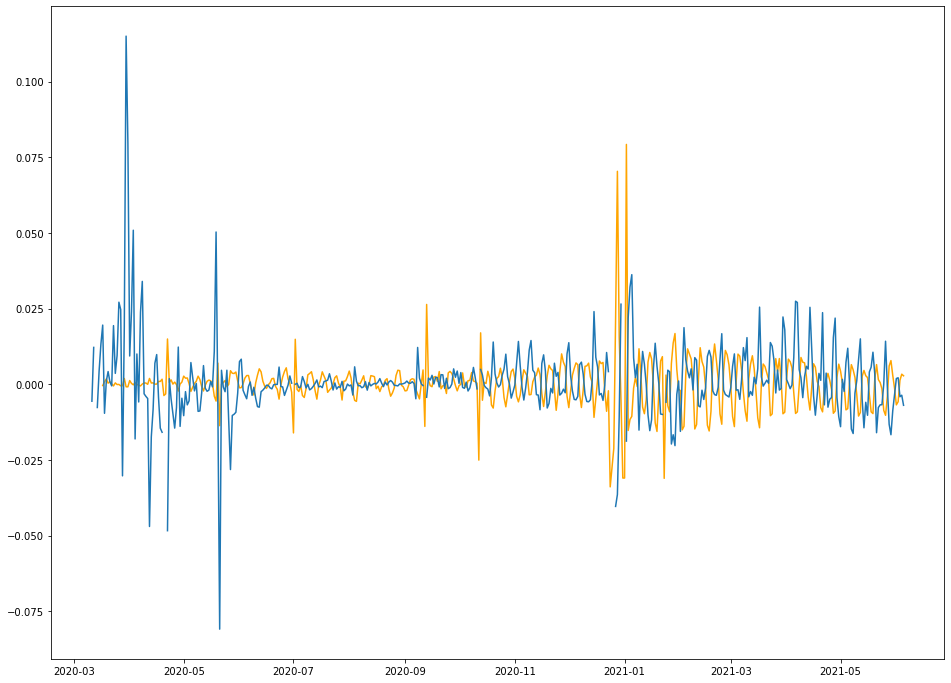

In [23]:
adj_tests = (tests - tests.rolling(7).mean()) / 1000

on_adj_tests = adj_tests["Ontario"]
on_pt = pt_1day["Ontario"]
on_adj_pt = on_pt - posrate["Ontario"]

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(16,12))

ax.plot(on_adj_tests.index, 10 * on_adj_tests.values, c="orange")
#axr = ax.twinx()
ax.plot(on_pt.index, on_adj_pt.values)

<AxesSubplot:xlabel='date'>

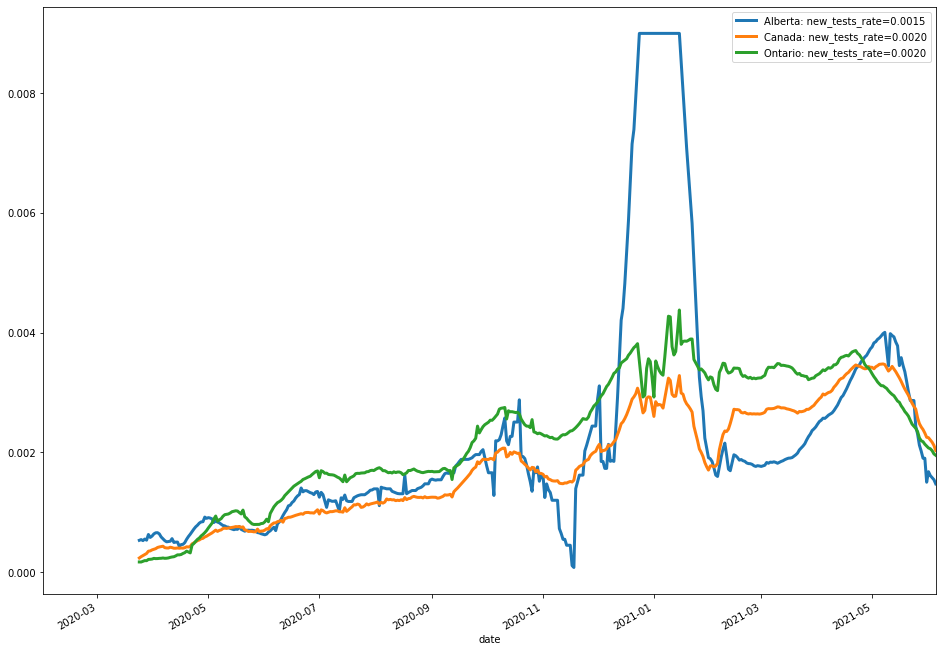

In [24]:
can.plot_var("new_tests_rate", "Ontario", "Alberta", "Canada", figsize=(16,12), ma_window=14)

In [25]:
data = np.empty((len(on_pt),2))
data[:,0] = on_adj_tests.values
data[:,1] = on_adj_pt.values
data.shape

(468, 2)

In [26]:
cov_img = np.ma.cov(np.ma.array(data.T, mask=(np.isnan(data.T))))
cov_img

masked_array(
  data=[[7.162491285692554e-07, --],
        [--, --]],
  mask=[[False,  True],
        [ True,  True]],
  fill_value=1e+20)

In [27]:
data

array([[            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan, -5.59811432e-03],
       [            nan,  1.21727861e-02],
       [            nan,             inf],
       [            nan, -7.67378875e-03],
       [            nan,  4.35894005e-03],
       [            nan,  1.32606408e-02],
       [-4.18978483e-05,  1.95503272e-02],
       [ 8.

In [28]:
dateparse = lambda x: datetime.date(*time.strptime(x, '%d-%m-%Y')[:3])
src = pd.read_csv("https://health-infobase.canada.ca/src/data/covidLive/covid19.csv",
                         error_bad_lines=False,
                         warn_bad_lines=False,
                         parse_dates=['date'],
                         date_parser= dateparse)
src.columns

Index(['pruid', 'prname', 'prnameFR', 'date', 'update', 'numconf', 'numprob',
       'numdeaths', 'numtotal', 'numtested', 'numtests', 'numrecover',
       'percentrecover', 'ratetested', 'ratetests', 'numtoday', 'percentoday',
       'ratetotal', 'ratedeaths', 'numdeathstoday', 'percentdeath',
       'numtestedtoday', 'numteststoday', 'numrecoveredtoday', 'percentactive',
       'numactive', 'rateactive', 'numtotal_last14', 'ratetotal_last14',
       'numdeaths_last14', 'ratedeaths_last14', 'numtotal_last7',
       'ratetotal_last7', 'numdeaths_last7', 'ratedeaths_last7',
       'avgtotal_last7', 'avgincidence_last7', 'avgdeaths_last7',
       'avgratedeaths_last7', 'raterecovered'],
      dtype='object')

In [29]:
feb = src[-15:]
feb.count()

pruid                  15
prname                 15
prnameFR               15
date                   15
update                 13
numconf                15
numprob                 0
numdeaths              15
numtotal               15
numtested               0
numtests               15
numrecover             15
percentrecover         15
ratetested              0
ratetests              14
numtoday               15
percentoday            15
ratetotal              14
ratedeaths             14
numdeathstoday         15
percentdeath           15
numtestedtoday          0
numteststoday          15
numrecoveredtoday      15
percentactive          15
numactive              15
rateactive             14
numtotal_last14        15
ratetotal_last14       14
numdeaths_last14       15
ratedeaths_last14      14
numtotal_last7         15
ratetotal_last7        14
numdeaths_last7        15
ratedeaths_last7       14
avgtotal_last7         15
avgincidence_last7     14
avgdeaths_last7        15
avgratedeath

In [30]:
src["update"].describe()

count    2119.000000
mean        0.907975
std         0.289129
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: update, dtype: float64

In [31]:
src[["prname", "numtests"]]

,prname,numtests
0,Ontario,0
1,British Columbia,0
2,Canada,0
3,Ontario,0
4,British Columbia,63
...,...,...
6832,Yukon,9129
6833,Northwest Territories,23728
6834,Nunavut,16119
6835,Repatriated travellers,76


In [32]:
np.nan + 5

nan

In [33]:
raw = pd.read_csv(can.src_url,error_bad_lines=False,warn_bad_lines=False)

In [34]:
for col in raw.columns:
    print(col)

pruid
prname
prnameFR
date
update
numconf
numprob
numdeaths
numtotal
numtested
numtests
numrecover
percentrecover
ratetested
ratetests
numtoday
percentoday
ratetotal
ratedeaths
numdeathstoday
percentdeath
numtestedtoday
numteststoday
numrecoveredtoday
percentactive
numactive
rateactive
numtotal_last14
ratetotal_last14
numdeaths_last14
ratedeaths_last14
numtotal_last7
ratetotal_last7
numdeaths_last7
ratedeaths_last7
avgtotal_last7
avgincidence_last7
avgdeaths_last7
avgratedeaths_last7
raterecovered


<AxesSubplot:>

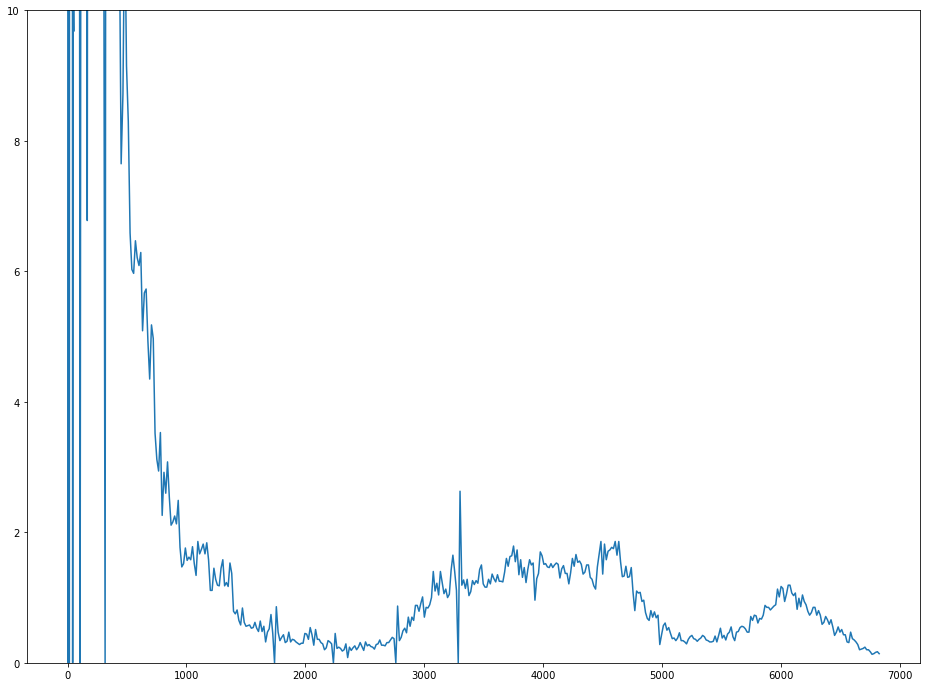

In [35]:
raw.loc[raw["prname"]=="Ontario"]["percentoday"].plot(figsize=(16,12), ylim=(0,10))